# Overload Attack in Pytorch
This notebook provides a demonstration showing how to use ART to launch the overload attack [1].

Overload attack has the following parameters:
* `estimator`: A trained YOLO5 model.
* `eps`: Maximum perturbation that the attacker can introduce.
* `max_iter`: The maximum number of iterations.
* `num_grid`: The number of grids for width and high dimension.
* `batch_size`: Size of the batch on which adversarial samples are generated.

[1] Overload: Latency Attacks on Object Detection for Edge Devices (https://arxiv.org/abs/2304.05370)

In [1]:
import logging
from io import BytesIO

import numpy as np
import requests
import torch
from PIL import Image

from art.attacks.evasion import OverloadPyTorch
from art.estimators.object_detection import PyTorchYolo

logger = logging.getLogger(__name__)

/home/runner/opt/miniconda/envs/dldev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cache found in /home/runner/.cache/torch/hub/ultralytics_yolov5_v7.0
YOLOv5 🚀 2023-11-25 Python-3.8.12 torch-1.13.1+cu116 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)



Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


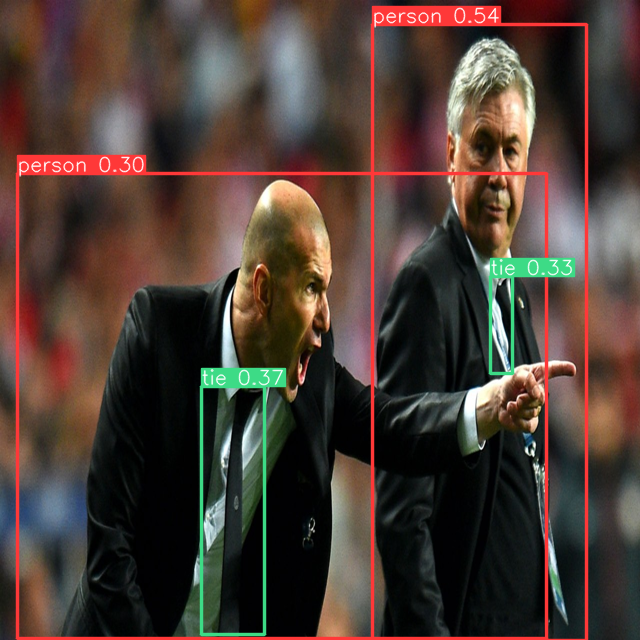

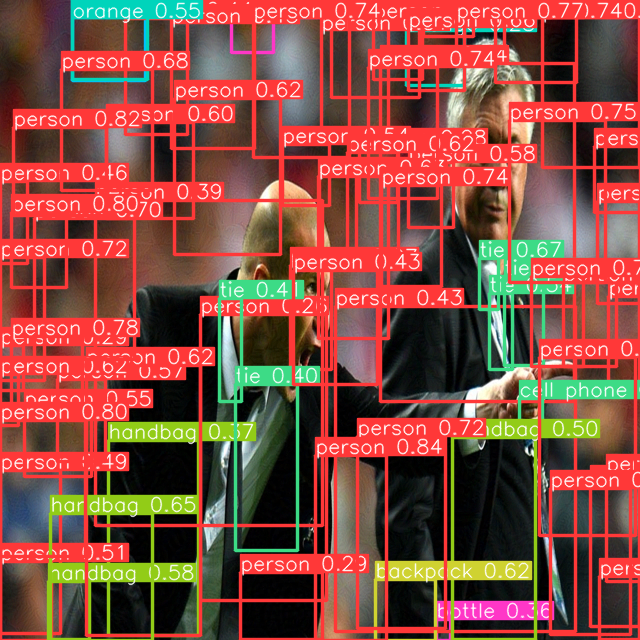

In [14]:
# Download yolov5s model
TARGET = 'https://ultralytics.com/images/zidane.jpg'
model = torch.hub.load('ultralytics/yolov5:v7.0',  model='yolov5s')

py_model = PyTorchYolo(model=model,
                       input_shape=(3, 640, 640),
                       channels_first=True)

# Download a sample image
response = requests.get(TARGET)
org_img = np.asarray(Image.open(BytesIO(response.content)).resize((640, 640)))
org_x = np.stack([org_img.transpose((2, 0, 1))], axis=0).astype(np.float32)

# Create the attacker
attack = OverloadPyTorch(py_model,
                         eps = 16.0 /255.0,
                         max_iter = 5,
                         num_grid = 10,
                         batch_size = 1)

# Generate the adversarial examples
x_adv = (attack.generate(org_x / 255.0) * 255.0)
adv_np = np.transpose(x_adv[0, :], (1, 2, 0)).astype(np.uint8)

# Visualize the predictions of the original example and the adversarial example
result = model(org_img)
result.show()
result = model(adv_np)
result.show()

In [20]:
# Download a sample video
TARGET = 'https://filesamples.com/samples/video/mp4/sample_1280x720.mp4'
response = requests.get(TARGET)
with open('demo.mp4', 'wb') as f:
    for chunk in response.iter_content(chunk_size=255): 
        if chunk:
            f.write(chunk)

In [34]:
import cv2
BS = 3
attack = OverloadPyTorch(py_model,
                         eps = 16.0 /255.0,
                         max_iter = 5,
                         num_grid = 10,
                         batch_size = BS)
vidcap = cv2.VideoCapture('demo.mp4')
np_video = np.empty((0, 640, 640, 3), dtype=np.float32)
bid = 0
while True:
    success, np_frame = vidcap.read()
    if not success:
        break

    np_frame = cv2.resize(np_frame.astype(np.float32), dsize=(640, 640))
    np_video = np.concatenate((np_video, np_frame[None, :]), axis=0)
    if np_video.shape[0] == BS:
        x_org = np_video.copy()
        x_adv = (attack.generate(np_video.transpose((0, 3, 1, 2)) / 255.0) * 255.0)
        
        # Save the adversarial examples to the file system and reset the container.
        np.save(f'overload_adv_{bid}', np_video)
        bid = bid + 1
        np_video = np.empty((0, 640, 640, 3), dtype=np.float32)
        break # Comment out the `break`` to continue processing the remaining frames

# Process remaining frames.
if np_video.shape[0] > 0:
    np.save(f'overload_adv_{bid}', np_video)

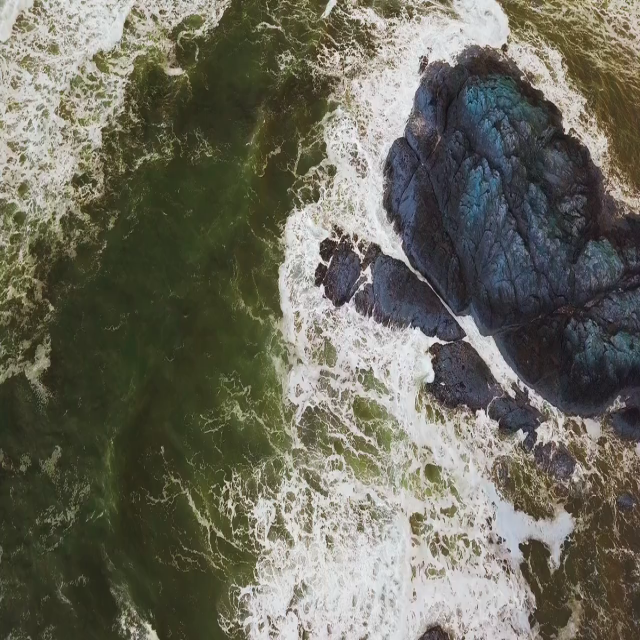

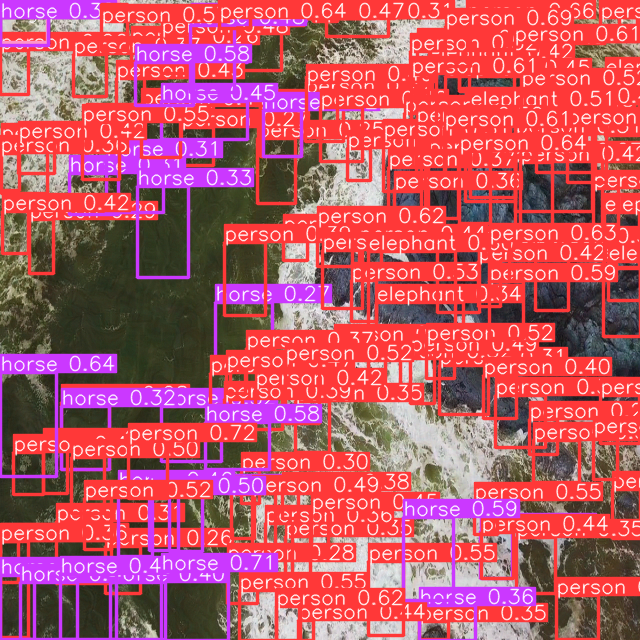

In [44]:
# Visualize the predictions of the original frame and the adversarial example
IDX = 0
result = model(x_org[IDX])
result.show()

adv_np = np.transpose(x_adv[IDX, :], (1, 2, 0)).astype(np.uint8)
result = model(adv_np)
result.show()